# Project Stage - III (Basic Machine Learning)

### Import essential libraries

In [56]:
import os
import math
# Science libraries
import pandas as pd
import numpy as np
# Ploting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go
import plotly
# Machine learning
from sklearn.metrics import mean_squared_error 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [57]:
# Create folder to hold the graphs
if not os.path.exists("images"):
    os.mkdir("images")

### Read and Filtter Dataset

#### Read dataset

In [58]:
# Read super Covid-19 dataframe with state as index. 
covid = pd.read_csv("../../../data/output/covid.csv", index_col=0)
# Read super Hosiptal dataframe with state as index. 
hospital = pd.read_csv("../../../data/output/COVID19_HOSBEDS_MERGE.csv", index_col=0)

In [59]:
FL_hospital = hospital.groupby('State').sum().loc['FL']

#### Clean the dataset.
remove unnessasery columns or rows.

In [60]:
# Drop unneccesary variables in Super covid-19 dataframe. 
covid.drop(["countyFIPS","stateFIPS"], axis=1, inplace=True)

# Drop unneccesary rows in Super COVID-19 dataframe.
covid.drop(
    covid.loc[covid['County Name'] == ("Statewide Unallocated" or 'New York City Unallocated')].index,
    inplace=True)

# Reset indexes after removing rows
covid.reset_index(drop=True, inplace=True)

#### Splite super covid dataset
Create dataframe that hold covid death and dataframe that hold covid cases.

In [61]:
# Regalare expression that will help filltering the data.
regex_cases = '(^[0-9]+[/]+[0-9]+[/]+[0-9]+[_]+[x])|^County Name$|^State$|^population$'
regex_deaths = '(^[0-9]+[/]+[0-9]+[/]+[0-9]+[_]+[y])|^County Name$|^State$|^population$'

cases = covid.filter(regex=regex_cases)
deaths = covid.filter(regex=regex_deaths)

Save the first three columns temprary so that we fix:
1. the date syntax.
2. Find the new cases/deaths

In [62]:
# Split the data: first three columns
covid_columns = covid[covid.columns[:3]]

# Split the data: fourth to the end columns
cases_data = cases[cases.columns[3:]]
deaths_data = deaths[deaths.columns[3:]]

#### Convert date type from String to Timestamp

In [63]:
# Fixing date string syntax
daily_cases = cases_data.rename(
    columns=lambda x: str(pd.to_datetime((x.split('_')[0]))).split(" ")[0],
    errors='raise')
daily_deaths = deaths_data.rename(
    columns=lambda x: str(pd.to_datetime((x.split('_')[0]))).split(" ")[0],
    errors='raise')

In [64]:
daily_cases

,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,2020-01-29,2020-01-30,2020-01-31,...,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09
0,0,0,0,0,0,0,0,0,0,0,...,2159,2173,2186,2197,2212,2230,2242,2267,2283,2304
1,0,0,0,0,0,0,0,0,0,0,...,6940,6966,6985,6995,7061,7097,7134,7188,7226,7263
2,0,0,0,0,0,0,0,0,0,0,...,1060,1061,1065,1074,1079,1080,1090,1092,1095,1098
3,0,0,0,0,0,0,0,0,0,0,...,873,878,883,890,897,907,917,924,926,932
4,0,0,0,0,0,0,0,0,0,0,...,2074,2095,2108,2162,2188,2222,2253,2286,2297,2335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3140,0,0,0,0,0,0,0,0,0,0,...,553,585,601,621,638,658,681,692,726,776
3141,0,0,0,0,0,0,0,0,0,0,...,796,814,847,862,873,897,922,932,977,1007
3142,0,0,0,0,0,0,0,0,0,0,...,479,488,492,510,518,529,542,544,551,568
3143,0,0,0,0,0,0,0,0,0,0,...,158,160,160,167,175,179,185,185,187,190


#### Find the daily new cases/death.
Calculate the diffrence between the current day and the day before it. The results is the new cases.

In [65]:
daily_cases = daily_cases.diff(axis=1).fillna(0)
daily_deaths = daily_deaths.diff(axis=1).fillna(0)

#### Merge the popolation, states and county names to the daily cases/deaths

In [66]:
new_cases = covid_columns.merge(daily_cases, left_index=True, right_index=True)
new_deaths = covid_columns.merge(daily_deaths, left_index=True, right_index=True)

In [67]:
new_cases.head()

,County Name,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09
0,Autauga County,AL,55869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,14.0,13.0,11.0,15.0,18.0,12.0,25.0,16.0,21.0
1,Baldwin County,AL,223234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,52.0,26.0,19.0,10.0,66.0,36.0,37.0,54.0,38.0,37.0
2,Barbour County,AL,24686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,4.0,9.0,5.0,1.0,10.0,2.0,3.0,3.0
3,Bibb County,AL,22394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,7.0,5.0,5.0,7.0,7.0,10.0,10.0,7.0,2.0,6.0
4,Blount County,AL,57826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,35.0,21.0,13.0,54.0,26.0,34.0,31.0,33.0,11.0,38.0


In [68]:
new_deaths.head()

,County Name,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09
0,Autauga County,AL,55869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Baldwin County,AL,223234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,0.0,6.0,0.0,0.0,0.0
2,Barbour County,AL,24686,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bibb County,AL,22394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,Blount County,AL,57826,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Linear regression models for predicting cases and deaths in Florida.

#### Florida cases

Filtter the dataset to get Florida state and it's counties

In [69]:
florida_cases_with_counties = new_cases.loc[new_cases['State'] == 'FL']
florida_deaths_with_counties = new_deaths.loc[new_deaths['State'] == 'FL']

In [70]:
florida_cases = pd.DataFrame(florida_cases_with_counties[florida_cases_with_counties.columns[3:]].sum(axis=0)).T
florida_deaths = pd.DataFrame(florida_deaths_with_counties[florida_deaths_with_counties.columns[3:]].sum(axis=0)).T

In [71]:
florida_cases =florida_cases.T
florida_deaths =florida_deaths.T

Fit a linewar regression model using sklearn's LinearRegression package

In [72]:
florida_cases_=florida_cases.reset_index().rename(columns={'index':'Date', 0:'Cases'})
florida_deaths_=florida_deaths.reset_index().rename(columns={'index':'Date', 0:'Deaths'})

In [73]:
florida_cases_

,Date,Cases
0,2020-01-22,0.0
1,2020-01-23,0.0
2,2020-01-24,0.0
3,2020-01-25,0.0
4,2020-01-26,0.0
...,...,...
288,2020-11-05,6303.0
289,2020-11-06,5279.0
290,2020-11-07,4447.0
291,2020-11-08,6570.0


In [74]:
df = florida_cases_
X = df.index.values.reshape(-1, 1)

model = LinearRegression()
model.fit(X, df.Cases)

x_range = np.linspace(X.min(), X.max(), 100)
y_range = model.predict(x_range.reshape(-1, 1))

fig = go.Figure()
cols = plotly.colors.DEFAULT_PLOTLY_COLORS

fig.add_trace(
    go.Scatter(
        x=df.index,
        y=df['Cases'],
        opacity=0.65,
        name="Cases",
        mode="markers",
        line=dict(width=2, color=cols[0]),
    ))
fig.add_trace(
    go.Scatter(
        x=x_range,
        y=y_range,
        opacity=0.65,
        name='Regression Fit',
        line=dict(width=2, color=cols[0]),
    ))
# Set custom x-axis labels
fig.update_xaxes(
    tickvals=df.index[0::40],
    ticktext=df['Date'][0::40],
)
fig.show()

In [75]:

mse = mean_squared_error(x_range, y_range)

rmse = math.sqrt(mse)
print(rmse)

3177.8821908944756


## Non-Linear regression models for predicting cases and deaths in Florida.

In [76]:
def format_coefs(coefs):
    equation_list = [f"{coef}x^{i}" for i, coef in enumerate(coefs)]
    equation = "$" +  " + ".join(equation_list) + "$"

    replace_map = {"x^0": "", "x^1": "x", '+ -': '- '}
    for old, new in replace_map.items():
        equation = equation.replace(old, new)

    return equation

In [77]:
df = florida_cases_
X = df.index.values.reshape(-1, 1)

x_range = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)

fig = px.scatter(df, x=df.index, y='Cases', opacity=0.65)
degrees = []
for degree in [1, 2, 3, 4, 5, 6]:
    poly = PolynomialFeatures(degree)
    poly.fit(X)
    X_poly = poly.transform(X)
    x_range_poly = poly.transform(x_range)

    model = LinearRegression(fit_intercept=False)
    model.fit(X_poly, df.Cases)
    y_poly = model.predict(x_range_poly)

    equation = format_coefs(model.coef_.round(2))
    fig.add_traces(go.Scatter(x=x_range.squeeze(), y=y_poly, name=equation))
    degrees.append(y_poly)
fig.show()

In [78]:
mse = mean_squared_error(x_range, degrees[5])

rmse = math.sqrt(mse)
print(rmse)

3838.1065369809803


In [79]:
from sklearn.model_selection import learning_curve

y = florida_cases_['Cases']
X = df.index.values.reshape(-1, 1)

def rms_error(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

def plot_learning_curve(degree=3):
    train_sizes = np.linspace(0.05, 1, 20)
    N_train, val_train, val_test = learning_curve(PolynomialRegression(degree),
                                                  X, y, train_sizes, cv=5,
                                                  scoring=rms_error)
    plt.figure(figsize=(10,8))
    plot_with_err(N_train, val_train, label='training scores')
    plot_with_err(N_train, val_test, label='validation scores')
    plt.xlabel('Training Set Size'); plt.ylabel('rms error')
    plt.ylim(0, 3)
    plt.xlim(5, 80)
    plt.legend()

In [80]:
# plot_learning_curve(1)

### Identify which counties are most at risk. Model for top 5 counties with cases within a state and observe their trends.

In [81]:
FL_cases = florida_cases_with_counties
FL_deaths = florida_deaths_with_counties

In [82]:
FL_cases

,County Name,State,population,2020-01-22,2020-01-23,2020-01-24,2020-01-25,2020-01-26,2020-01-27,2020-01-28,...,2020-10-31,2020-11-01,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-07,2020-11-08,2020-11-09
322,Alachua County,FL,269043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,49.0,124.0,54.0,82.0,71.0,83.0,51.0,35.0,41.0,138.0
323,Baker County,FL,29210,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,10.0,6.0,8.0,7.0,14.0,4.0,3.0,5.0,4.0
324,Bay County,FL,174705,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,13.0,26.0,74.0,34.0,47.0,27.0,21.0,31.0,80.0
325,Bradford County,FL,28201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,2.0,3.0,0.0,8.0,4.0,1.0,8.0,4.0
326,Brevard County,FL,601942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,106.0,37.0,108.0,146.0,161.0,123.0,111.0,143.0,108.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384,Union County,FL,15237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,8.0,4.0,8.0,8.0,5.0,2.0,1.0,2.0,3.0
385,Volusia County,FL,553284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,51.0,81.0,81.0,97.0,96.0,78.0,79.0,118.0,96.0,95.0
386,Wakulla County,FL,33739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,7.0,11.0,5.0,3.0,4.0,12.0,5.0,12.0,1.0
387,Walton County,FL,74071,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,30.0,27.0,33.0,34.0,22.0,79.0,237.0,69.0,20.0


In [83]:
florida_cases_with_counties=florida_cases_with_counties.T
florida_deaths_with_counties=florida_deaths_with_counties.T

In [84]:
florida_cases_with_counties_ =florida_cases_with_counties[3:].reset_index().rename(columns={'index':'Date'})

In [85]:
florida_cases_with_counties_

,Date,322,323,324,325,326,327,328,329,330,...,379,380,381,382,383,384,385,386,387,388
0,2020-01-22,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-23,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-26,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288,2020-11-05,83,14,47,8,123,803,12,25,33,...,104,80,17,9,5,5,78,4,22,10
289,2020-11-06,51,4,27,4,111,567,6,38,38,...,61,76,21,2,9,2,79,12,79,5
290,2020-11-07,35,3,21,1,143,421,2,40,53,...,65,59,23,3,5,1,118,5,237,11
291,2020-11-08,41,5,31,8,108,825,3,43,91,...,117,78,16,7,1,2,96,12,69,4


In [86]:
florida_cases_with_counties_[322]

0        0
1        0
2        0
3        0
4        0
      ... 
288     83
289     51
290     35
291     41
292    138
Name: 322, Length: 293, dtype: object

In [87]:
# # Cases
Miami = FL_cases[(FL_cases['County Name'] == 'Miami-Dade County')][FL_cases.columns[3:]].T
Broward = FL_cases[(FL_cases['County Name'] == 'Broward County')][FL_cases.columns[3:]].T
Orange = FL_cases[(FL_cases['County Name'] == 'Orange County')][FL_cases.columns[3:]].T
Palm =FL_cases[(FL_cases['County Name'] == 'Palm Beach County')][FL_cases.columns[3:]].T
Gadsden = FL_cases[(FL_cases['County Name'] == 'Gadsden County')][FL_cases.columns[3:]].T

# # Deaths
Union_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Union County')][FL_deaths.columns[3:]].T
Madison_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Madison County')][FL_deaths.columns[3:]].T
Lafayette_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Lafayette County')][FL_deaths.columns[3:]].T
Gilchrist_Deaths =FL_deaths[(FL_deaths['County Name'] == 'Gilchrist County')][FL_deaths.columns[3:]].T
Calhoun_Deaths = FL_deaths[(FL_deaths['County Name'] == 'Calhoun County')][FL_deaths.columns[3:]].T

In [88]:
fig = go.Figure()
days = florida_cases_with_counties_.index.values.reshape(-1, 1)
def draw(df, name):
    X = days

    model = LinearRegression()
    model.fit(X, df.values.reshape(-1, 1))

    x_range = np.linspace(X.min(), X.max(), df.size)
    y_range = model.predict(x_range.reshape(-1, 1))
    color1 = list(np.random.choice(range(256), size=3))
    Y_Range = pd.Series(y_range[:,0], index=df.index)
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[df.columns[0]],
            opacity=0.65,
            name=name,
            mode="markers",
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=Y_Range,
            opacity=0.65,
            name='Regression ' + name,
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
# # Set custom x-axis labels
# fig.update_xaxes(
#     tickvals=df.index[0::40],
#     ticktext=df['Date'][0::40],
# )


draw(Miami, 'Miami-Dade')
draw(Broward, 'Broward')
draw(Orange, 'Orange')
draw(Palm, 'Palm Beach')
draw(Gadsden, 'Gadsden')


fig.show()

Florida's counties

In [89]:
fig = go.Figure()
for i in range(322, florida_cases_with_counties_.keys()[-1]):
    df = florida_cases_with_counties_
    X = df.index.values.reshape(-1, 1)

    model = LinearRegression()
    model.fit(X, df[i])

    x_range = np.linspace(X.min(), X.max(), 100)
    y_range = model.predict(x_range.reshape(-1, 1))

    color1 = list(np.random.choice(range(256), size=3))
    fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[i],
            opacity=0.65,
            name=florida_cases_with_counties[i][0],
            mode="markers",
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
    fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_range,
            opacity=0.65,
            name='Regression ' + florida_cases_with_counties[i][0],
            line=dict(width=2, color=f'rgb({color1[0]},{color1[1]},{color1[2]} )'),
        ))
# Set custom x-axis labels
fig.update_xaxes(
    tickvals=df.index[0::40],
    ticktext=df['Date'][0::40],
)
fig.show()

Utilize the hospital data to calculate the point of no return for a state. Use percentage occupancy / utilization to see which states are close and what their trend looks like.

In [90]:
FL_hospital['BED_UTILIZATION']

146.94586611899993

In [91]:
FL_DR = FL_deaths[FL_deaths.columns[-1]].sum() / FL_hospital['BED_UTILIZATION']
FL_DR

0.39470317561046836

### Utilize decision tree, random forest, and ARIMA (https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) based models to compare and contrast the performance of each. X-variable is the previous weeks data, Y-variable is current week data. So you are predicting one week in advance. Calculate RMSE error. This is just based on number of cases.


#### Utilize decision tree

In [92]:
from sklearn.tree import DecisionTreeRegressor

y = florida_cases.reset_index()[0].values.reshape(-1, 1)
X = days

# Fit regression model
regressor = DecisionTreeRegressor()
regressor.fit(X, y)


# Predict
x_range = np.linspace(294, df.size + 7,  7)
y_range = model.predict(x_range.reshape(-1, 1))

print(x_range)
fig = go.Figure()
fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_range,
        ))
fig.show()



[  294.          3566.83333333  6839.66666667 10112.5
 13385.33333333 16658.16666667 19931.        ]


In [105]:
from sklearn.tree import DecisionTreeRegressor    # Import decision tree regression model

y = florida_cases.reset_index()[0].values.reshape(-1, 1)
X = days

sort_idx = X.flatten().argsort()                  # Sort X and y by ascending values of X
X = X[sort_idx]
y = y[sort_idx]

tree = DecisionTreeRegressor(criterion='mse',     # Initialize and fit regressor
                             max_depth=3)         
tree.fit(X, y)

DecisionTreeRegressor(max_depth=3)

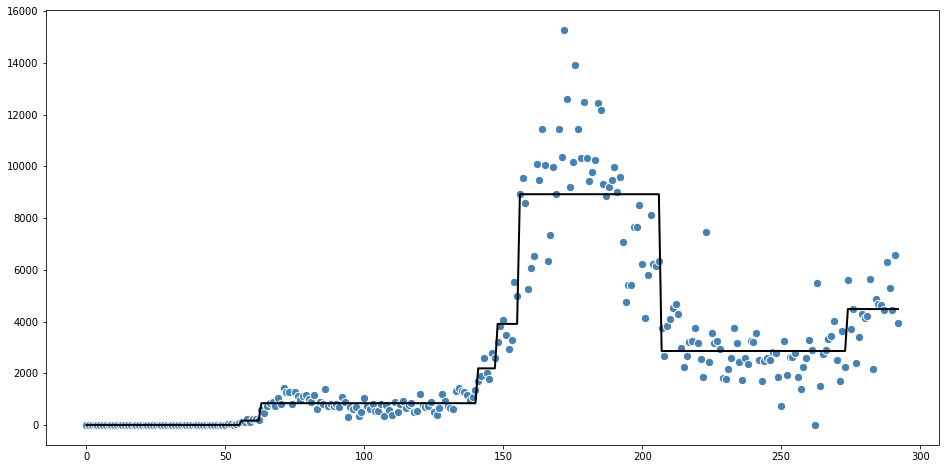

In [103]:
plt.figure(figsize=(16, 8))
plt.scatter(X, y, c='steelblue',                  # Plot actual target against features
            edgecolor='white', s=70)
plt.plot(X, tree.predict(X),                      # Plot predicted target against features
         color='black', lw=2)
plt.show()

In [93]:
rmse = np.sqrt(mean_squared_error(x_range, y_range))
print(rmse)

10760.18279908586


#### Utilize random forest

In [94]:
from sklearn.ensemble import RandomForestRegressor
from numpy import asarray


In [95]:
def random_forest_forecast(train, testX):
    # transform list into array
    train = asarray(train)
    # split into input and output columns
    trainX, trainy = train.index, train
    
    # fit model
    model = RandomForestRegressor(n_estimators=1000)
    model.fit(trainX, trainy)
    # make a one-step prediction
    yhat = model.predict([testX])
    return yhat[0]

In [96]:
# forecast monthly births with random forest
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values


# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
    predictions = list()
    # split dataset
    train, test = data[:-n_test, :], data[-n_test:, :]
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        train = np.asarray(train)
        
        # split into input and output columns
        trainX, trainy = train[:, :-1], train[:, -1]
        # fit model
        model = RandomForestRegressor(n_estimators=1000)
        model.fit(trainX, trainy)
        # make a one-step prediction
        yhat = model.predict([testX])[0]
        # store forecast in list of predictions
        predictions.append(yhat)
        
        # add actual observation to history for the next loop
        history.append(test[i])
        
        # summarize progress
        print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
        
    # estimate prediction error
    error = np.sqrt(mean_squared_error(test[:, -1], predictions))
    return error, test[:, -1], predictions

# load the dataset
df = florida_cases.reset_index()[0]
# transform the time series data into supervised learning
data = series_to_supervised(df, n_in=6)
# evaluate
mae, y, yhat = walk_forward_validation(data, 7)
print(f'RMSE: {mae}')

fig = go.Figure()
fig.add_trace(
        go.Scatter(
            x=[293,294,295,296,297,298,299],
            y=yhat,
            mode="lines"
        ))
df = florida_cases.reset_index()[0].to_frame()
fig.add_trace(
        go.Scatter(
            x=df.index,
            y=df[0],
            mode="lines"
        ))
fig.show()

>expected=4653.0, predicted=5300.2
>expected=4458.0, predicted=4943.3
>expected=6303.0, predicted=4846.5
>expected=5279.0, predicted=4164.0
>expected=4447.0, predicted=6300.3
>expected=6570.0, predicted=5181.2
>expected=3942.0, predicted=5825.0
RMSE: 1359.0040742049725


<ipython-input-106-c3e11634a474>:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



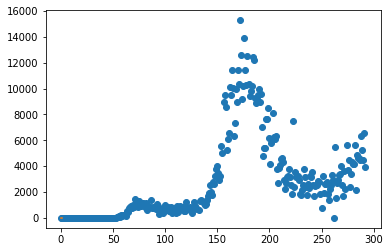

In [106]:
# Fit a Random Forest
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
model.fit(X, y)

# Plot the data and the model prediction
X_fit = np.linspace(0, 1, 100)[:, np.newaxis]
y_fit = model.predict(X_fit)

plt.plot(X.squeeze(), y, 'o')
plt.plot(X_fit.squeeze(), y_fit);

In [97]:
df = florida_cases.reset_index()[0]
print(df.values)
X = days

model = RandomForestRegressor()
model.fit(X, df.values.reshape(-1, 1))

# x_range = np.linspace(X.min(), X.max(), df.size)
# y_range = model.predict(x_range.reshape(-1, 1))
# Predict
x_range = np.linspace(294, df.size + 100,  100)
y_range = model.predict(x_range.reshape(-1, 1))
print(y_range)
# Y_Range = pd.Series(y_range[:,0], index=df.index)
fig = go.Figure()
fig.add_trace(
        go.Scatter(
            x=x_range,
            y=y_range,
        ))
fig.show()

[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00 0.0000e+00 4.0000e+00 3.0000e+00 5.0000e+00
 1.1000e+01 6.0000e+00 1.0000e+01 2.3000e+01 3.2000e+01 4.0000e+00
 3.8000e+01 7.3000e+01 1.1700e+02 1.0100e+02 2.2000e+02 1.1200e+02
 2.4300e+02 2.2300e+02 1.8500e+02 5.6300e+02 4.8300e+02 7.4000e+02
 8.4000e+02 9.0900e+02 7.5500e+02 1.0370e+03 8.1700e+02 1.4430e+03
 1.2590e+03 1.2760e+03 8.1200e+02 1.2780e+03 1.1210e+03 9.5100e+02
 1.1280e+03 1.1420e+03 1.0150e+03 8.7500e+02 1.1610e+03 6.0500e+02
 8.9300e+02 8.2200e+02 1.4070e+03 7.4400e+02 8.2100e+02 7.4400

<ipython-input-97-f57aa625f0e6>:6: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [98]:
rmse = np.sqrt(mean_squared_error(x_range, y_range))
print(rmse)

4398.584718986324


#### Utilize ARIMA 

<ipython-input-99-e492ba13f602>:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

C:\Users\CodingTheories\Anaconda3\envs\CSC_405\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)


C:\Users\Co

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  292
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2449.006
Method:                       css-mle   S.D. of innovations           1060.789
Date:                Sun, 15 Nov 2020   AIC                           4912.013
Time:                        17:26:33   BIC                           4937.750
Sample:                    01-23-2020   HQIC                          4922.322
                         - 11-09-2020                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1536     22.494      0.763      0.446     -26.934      61.241
ar.L1.D.y     -0.5207      0.057     -9.180      0.000      -0.632      -0.409
ar.L2.D.y     -0.3770      0.062     -6.035      0.0

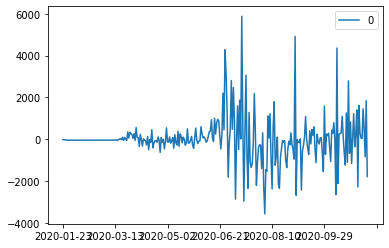

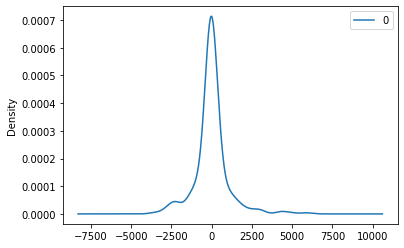

                 0
count   292.000000
mean     -0.217590
std    1062.610627
min   -3573.532558
25%    -226.090982
50%     -47.618358
75%     236.235933
max    5882.265589


In [99]:
from pandas import read_csv
from pandas import datetime
from pandas import DataFrame
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot



series = florida_cases[0]
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

predicted=9607.741055, expected=7058.000000


C:\Users\CodingTheories\Anaconda3\envs\CSC_405\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




predicted=7910.428688, expected=4755.000000
predicted=6250.862897, expected=5430.000000
predicted=7100.305551, expected=5422.000000
predicted=6100.793053, expected=7667.000000
predicted=8028.209740, expected=7657.000000
predicted=7467.371363, expected=8499.000000
predicted=7536.540650, expected=6212.000000
predicted=6259.988326, expected=4153.000000
predicted=4628.662548, expected=5807.000000
predicted=6727.082519, expected=8127.000000
predicted=7891.883934, expected=6219.000000
predicted=6413.319590, expected=6133.000000
predicted=6492.630174, expected=6328.000000
predicted=6131.712249, expected=3766.000000
predicted=4193.716573, expected=2673.000000
predicted=4512.064265, expected=3832.000000
predicted=4752.482692, expected=4112.000000
predicted=4388.933284, expected=4543.000000
predicted=4991.319027, expected=4670.000000
predicted=4553.615330, expected=4287.000000
predicted=3874.431407, expected=2966.000000
predicted=3278.309170, expected=2250.000000
predicted=2904.418292, expected=

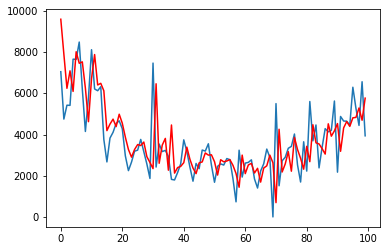

In [100]:
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
print('Test RMSE: %.3f' % np.sqrt(error))
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()